Accuracy: 0.926

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       437
           1       0.72      0.68      0.70        63

    accuracy                           0.93       500
   macro avg       0.84      0.82      0.83       500
weighted avg       0.92      0.93      0.93       500



e:\oosun\Documents\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


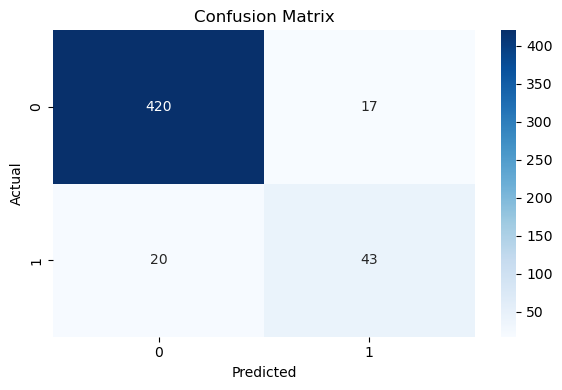

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

#Step 1: Import CSVs
df_train = pd.read_csv('../Data/train_data.csv', delimiter=",") 
df_test = pd.read_csv('../Data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns = ["Rain"])
y_train = df_train['Rain']

X_test = df_test.drop(columns = ["Rain"])
y_test = df_test['Rain']

#Step 3: Feature sclaing
scaler = StandardScaler()  
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Step 4: Tune and train Logistic Regression model using GridSearchCV
#Define the model
ln = LogisticRegression(solver='lbfgs', max_iter=500)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],    # Regularization strength
    'penalty': ['l2'],               # Using L2 penalty (default for lbfgs)
    'max_iter': [100, 200, 500]      # Try increasing iterations in case it doesn't converge
}
base_model = LogisticRegression(solver='lbfgs', multi_class='auto')
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Use best model found
ln = grid_search.best_estimator_

#Setp 5: predictions
predictions = ln.predict(X_test_scaled)
predictions  #Returns wether it will rain or not

#Step 6: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

#Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 7: Save the model as pkl file in artifacts   
with open("../Artifacts/regression_model.pkl", "wb") as file:
    pickle.dump(ln, file)
with open("../Artifacts/regression_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

#Step 8: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual Rain"] = y_test.values
comparison_df["Predicted Rain"] = predictions

comparison_df.to_csv("../Artifacts/regression_prediction.csv", index=False)  
